# Multi-genre natural language inference(MNLI)

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

## [MYCODE] Kaggle Data 준비 (MultiNLI (Multi-Genre Natural Language Inference))

In [2]:
from google.colab import files
files.upload()  # 이 명령을 실행하면 파일을 업로드하는 창이 뜹니다.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hueokjun","key":"71e8b4674cbd15c3edee7b9a8eb199e7"}'}

In [3]:
#kaggle.json을 올바른 경로에 저장
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [4]:
!kaggle datasets download -d thedevastator/unlocking-language-understanding-with-the-multin

Dataset URL: https://www.kaggle.com/datasets/thedevastator/unlocking-language-understanding-with-the-multin
License(s): CC0-1.0
 99% 108M/109M [00:05<00:00, 24.2MB/s]
100% 109M/109M [00:05<00:00, 19.7MB/s]


In [5]:
!unzip unlocking-language-understanding-with-the-multin.zip -d /content/

Archive:  unlocking-language-understanding-with-the-multin.zip
  inflating: /content/train.csv      
  inflating: /content/validation_matched.csv  
  inflating: /content/validation_mismatched.csv  


premise:  첫 번째 문장 (전제)

premise_binary_parse:  문법적 요소들(주어, 동사, 목적어 등)과 그 관계

hypothesis: 두 번째 문장 (가설)

hypothesis_binary_parse:  문법적 요소와 그 관계를 트리 구조

genre: 해당 문장이 속하는 장르

label: 자연어 추론의 답. MNLI는 3개의 레이블을 사용
*   0: Contradiction (모순) - 가설이 전제와 모순됨
*   1: Entailment (함의) - 가설이 전제로부터 의미상 귀결됨
*   2: Neutral (중립) - 가설과 전제 간에 명확한 관계가 없음  





In [6]:
import pandas as pd

# 데이터셋 로드
data = pd.read_csv('/content/train.csv')
print(data.head())  # 데이터의 상위 5개 행 확인

   promptID   pairID                                            premise  \
0     31193   31193n  Conceptually cream skimming has two basic dime...   
1    101457  101457e  you know during the season and i guess at at y...   
2    134793  134793e  One of our number will carry out your instruct...   
3     37397   37397e  How do you know? All this is their information...   
4     50563   50563n  yeah i tell you what though if you go price so...   

                                premise_binary_parse  \
0  ( ( Conceptually ( cream skimming ) ) ( ( has ...   
1  ( you ( ( know ( during ( ( ( the season ) and...   
2  ( ( One ( of ( our number ) ) ) ( ( will ( ( (...   
3  ( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...   
4  ( yeah ( i ( ( tell you ) ( what ( ( though ( ...   

                                       premise_parse  \
0  (ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...   
1  (ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...   
2  (ROOT (S (NP (NP (CD One)) (PP (IN of) (N

## [MYCODE] Train_loader , Test_loader 정의

tokenizer를 불러옵니다.

In [7]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
ds = load_dataset('glue','mnli')


train_data = ds['train'].select(range(10000))  # 첫 10,000개 샘플만 선택

def collate_fn(batch):
    max_len = 128  # 최대 길이를 설정 (BERT 기반 모델은 일반적으로 128 정도가 적당)
    texts, labels = [], []

    for row in batch:
        premise = row['premise']  # Premise
        hypothesis = row['hypothesis']  # Hypothesis
        label = row['label']  # 레이블

        # Premise와 Hypothesis 두 문장을 하나로 결합하여 토큰화
        text = f"{premise} [SEP] {hypothesis}"
        texts.append(text)
        labels.append(label)

    # 두 문장을 토큰화하고 padding 및 truncation 적용
    tokenizer_encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
    input_text = tokenizer_encodings['input_ids']
    masks = tokenizer_encodings['attention_mask'] #[MYCODE]학습 시 attention_mask를 사용하기 위함

    # 레이블을 Tensor로 변환
    labels = torch.tensor(labels)

    return input_text, labels, masks

# DataLoader 준비
train_loader = DataLoader(
   train_data, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['validation_matched'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [9]:
for texts, labels, masks in train_loader:
  print(f"texts.shape : {texts.shape}")
  print(f"mask.shape : {masks.shape}")
  print(f"labels.shape : {labels.shape}")
  print(f"text :{texts}")
  print(f"mask : {masks}")
  print(f"labels : {labels}")
  break

texts.shape : torch.Size([64, 121])
mask.shape : torch.Size([64, 121])
labels.shape : torch.Size([64])
text :tensor([[  101,  2006,  1037,  ...,     0,     0,     0],
        [  101,  2073,  2079,  ...,     0,     0,     0],
        [  101, 13600,  1998,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2236,  ...,     0,     0,     0],
        [  101,  2061,  2027,  ...,     0,     0,     0],
        [  101,  1996,  3885,  ...,     0,     0,     0]])
mask : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
labels : tensor([0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 1, 2, 2,
        2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1])


In [10]:
for batch in train_loader:
  texts, labels, masks = batch
  outputs= torch.unique(labels)

num_labels = len(outputs)

# 두 문장간의 관계 0 : 모순 / 1 : 연결  / 2 : 무관
print(f"{outputs}  ouput_num : {len(outputs)}")

tensor([0, 1, 2])  ouput_num : 3


## [MYCODE] pre-trained DistilBERT 선언

In [11]:
encoder_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
encoder_model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [12]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self,encoder_model,num_labels):
    super().__init__()

    self.encoder = encoder_model
    self.classifier = nn.Linear(768, num_labels)

  def forward(self, x, masks):
    x = self.encoder(x, masks)['last_hidden_state']
    x = self.classifier(x[:, 0, :]) #(last_hidden_state) -> [batch_size, sequence_length, hidden_size]

    return x


model = TextClassifier(encoder_model,num_labels)

In [13]:
for param in model.encoder.parameters():
  param.requires_grad = False

## [MYCODE][LOG] 모델 학습 및 loss,acc 출력

In [14]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() #[MYCODE] CrossEntropyLoss 사용
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 50
train_loss = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    preds = model(inputs, masks)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  # train_loss에 각 에포크의 총 손실 기록
  train_loss.append(total_loss)

Epoch   0 | Train Loss: 169.60433840751648
Epoch   1 | Train Loss: 164.99912971258163
Epoch   2 | Train Loss: 163.21067011356354
Epoch   3 | Train Loss: 160.98879158496857
Epoch   4 | Train Loss: 160.38097149133682
Epoch   5 | Train Loss: 159.66979789733887
Epoch   6 | Train Loss: 159.13010650873184
Epoch   7 | Train Loss: 157.9892464876175
Epoch   8 | Train Loss: 157.51775515079498
Epoch   9 | Train Loss: 157.08051753044128
Epoch  10 | Train Loss: 156.65110343694687
Epoch  11 | Train Loss: 156.36108976602554
Epoch  12 | Train Loss: 156.32382541894913
Epoch  13 | Train Loss: 155.398339509964
Epoch  14 | Train Loss: 155.50092911720276
Epoch  15 | Train Loss: 155.6853750348091
Epoch  16 | Train Loss: 155.44427371025085
Epoch  17 | Train Loss: 154.90476697683334
Epoch  18 | Train Loss: 154.63223218917847
Epoch  19 | Train Loss: 155.19120508432388
Epoch  20 | Train Loss: 154.28497076034546
Epoch  21 | Train Loss: 154.5068443417549
Epoch  22 | Train Loss: 154.04261356592178
Epoch  23 | Trai

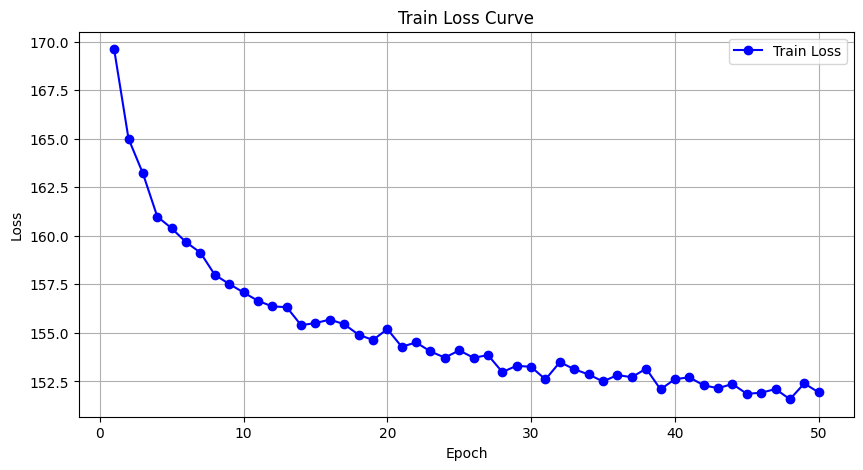

In [15]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_loss, label='Train Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    preds = model(inputs, masks)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


with torch.no_grad():
  model.eval()
  pre_train_accuracies = accuracy(model, train_loader)
  pre_test_accuracies = accuracy(model, test_loader)
  print(f"=========> Train acc: {pre_train_accuracies:.3f} | Test acc: {pre_test_accuracies:.3f}")

=========> Train acc: 0.554 | Test acc: 0.491


epoch 10회 진행 시 =========> Train acc: 0.527 | Test acc: 0.474

조금 더 정확도를 높여보고자 epoch 를 50회로 늘려서 진행함. epoch를 늘려 정확도가 조금 증가됨을 확인함.

epoch 50회 진행 시 =========> Train acc: 0.554 | Test acc: 0.491

## [MYCODE][LOG] Pre-train 하지 않는 transformer를 만들기 위해 기존 모델 초기화

In [17]:
from transformers import DistilBertModel, DistilBertConfig

# DistilBERT 모델을 non-pre-trained 상태로 초기화
config = DistilBertConfig()  # 기본 설정으로 초기화 (pre-trained X)
non_pretrained_model = DistilBertModel(config)

# 새로운 non-pretrained 모델 정의
non_pretrained_model = TextClassifier(non_pretrained_model, num_labels)

Non-pre-trained 모델에서는 모든 계층이 학습 대상이므로, 이 구문을 적용할 필요는 없습니다.

for param in model.encoder.parameters():
  param.requires_grad = False

In [18]:
lr = 0.001
non_pretrained_model = non_pretrained_model.to('cuda')
non_pretrained_loss_fn = nn.CrossEntropyLoss() #[MYCODE] CrossEntropyLoss 사용
non_pretrained_optimizer = Adam(non_pretrained_model.parameters(), lr=lr)
n_epochs = 50
nonpre_train_loss = []

for epoch in range(n_epochs):
  total_loss = 0.
  non_pretrained_model.train()
  for data in train_loader:
    non_pretrained_model.zero_grad()
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    preds = non_pretrained_model(inputs, masks)
    loss = non_pretrained_loss_fn(preds, labels)
    loss.backward()
    non_pretrained_optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | nonpre_train_loss: {total_loss}")
  #1시간 2분 걸림...

  # train_loss에 각 에포크의 총 손실 기록
  nonpre_train_loss.append(total_loss)

Epoch   0 | nonpre_train_loss: 223.46297872066498
Epoch   1 | nonpre_train_loss: 173.9017071723938
Epoch   2 | nonpre_train_loss: 175.2127387523651
Epoch   3 | nonpre_train_loss: 174.08632373809814
Epoch   4 | nonpre_train_loss: 173.10852789878845
Epoch   5 | nonpre_train_loss: 173.7284255027771
Epoch   6 | nonpre_train_loss: 173.9857577085495
Epoch   7 | nonpre_train_loss: 173.07240533828735
Epoch   8 | nonpre_train_loss: 172.69027423858643
Epoch   9 | nonpre_train_loss: 172.6057915687561
Epoch  10 | nonpre_train_loss: 172.38824462890625
Epoch  11 | nonpre_train_loss: 172.507204413414
Epoch  12 | nonpre_train_loss: 172.41636669635773
Epoch  13 | nonpre_train_loss: 172.4017847776413
Epoch  14 | nonpre_train_loss: 172.36045813560486
Epoch  15 | nonpre_train_loss: 172.0375553369522
Epoch  16 | nonpre_train_loss: 171.8719346523285
Epoch  17 | nonpre_train_loss: 172.05339658260345
Epoch  18 | nonpre_train_loss: 172.01479399204254
Epoch  19 | nonpre_train_loss: 172.13147914409637
Epoch  20 

##[MYCODE] Pre-trained vs Non Pre-trained Loss Comparison


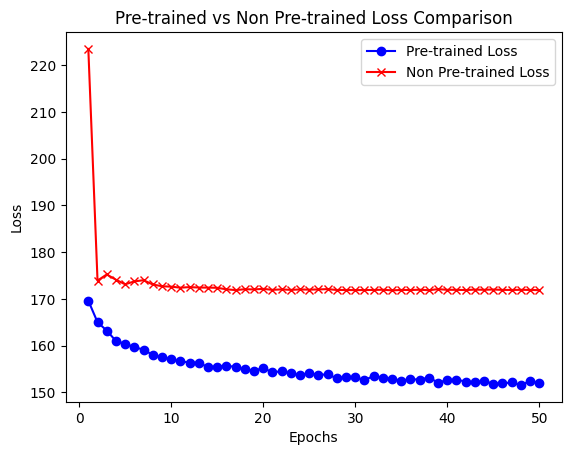

In [19]:
# 그래프 그리기
plt.plot(range(1, n_epochs+1), train_loss, label='Pre-trained Loss', color='blue', marker='o')
plt.plot(range(1, n_epochs+1), nonpre_train_loss, label='Non Pre-trained Loss', color='red', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Pre-trained vs Non Pre-trained Loss Comparison')
plt.legend()
plt.show()

## [MYCODE] Train vs Test Accuracy for Pre-trained and Non Pre-trained Models

In [20]:
with torch.no_grad():
  non_pretrained_model.eval()
  non_pre_train_acc = accuracy(non_pretrained_model, train_loader)
  non_pre_test_acc = accuracy(non_pretrained_model, test_loader)
  print(f"=========> Train acc: {non_pre_train_acc:.3f} | Test acc: {non_pre_test_acc:.3f}")

=========> Train acc: 0.369 | Test acc: 0.327


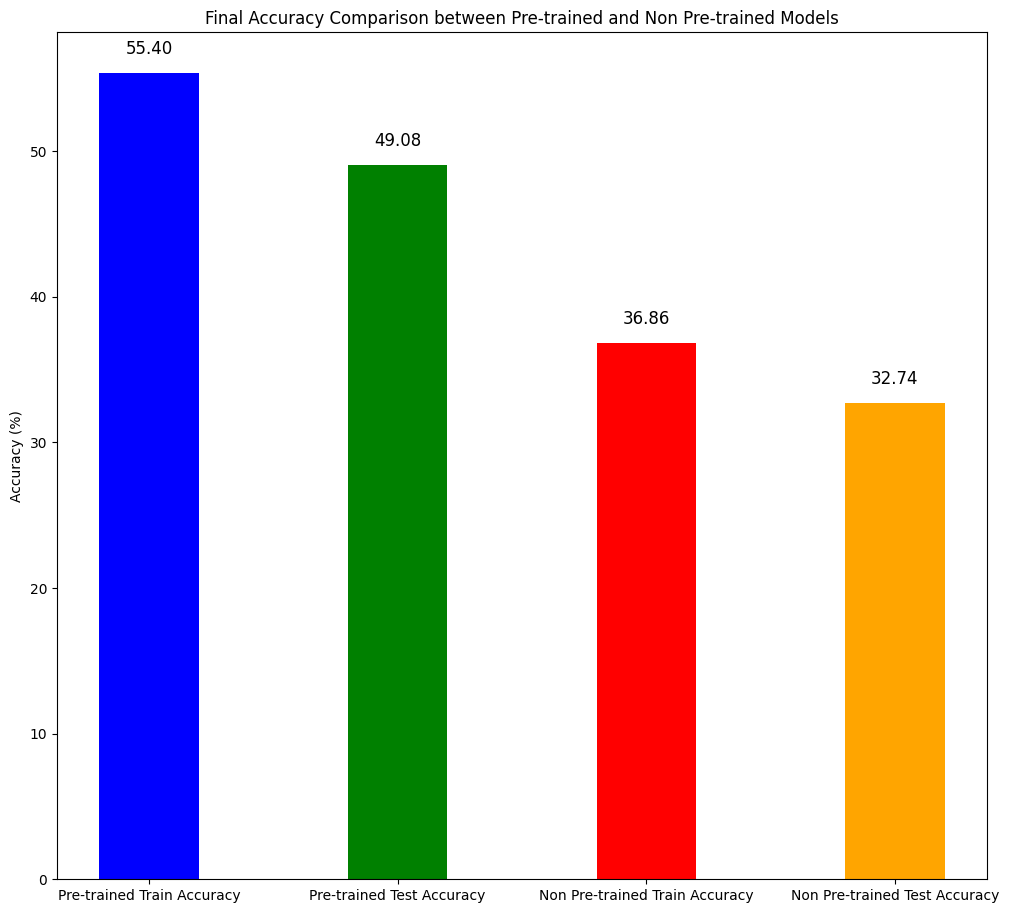

In [44]:
# 정확도를 리스트로 만듦
accuracies = [pre_train_accuracies, pre_test_accuracies, non_pre_train_acc, non_pre_test_acc]

# 리스트의 모든 항목에 100을 곱함
accuracies = [acc * 100 for acc in accuracies]

# 레이블 리스트
labels = ['Pre-trained Train Accuracy', 'Pre-trained Test Accuracy',
          'Non Pre-trained Train Accuracy', 'Non Pre-trained Test Accuracy']

# 그래프 그리기
plt.figure(figsize=(12, 11))
bars = plt.bar(labels, accuracies, color=['blue', 'green', 'red', 'orange'],width=0.4)

# 각 바 위에 정확도 값 표시
for bar in bars:
    height = bar.get_height()  # 바의 높이 (정확도 값)
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,  # x 위치와 y 위치
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)  # 텍스트 내용

# 그래프 제목과 레이블 추가
plt.ylabel('Accuracy (%)')  # 100배를 곱했으므로 퍼센트 단위로 표기
plt.title('Final Accuracy Comparison between Pre-trained and Non Pre-trained Models')

# 그래프 출력
plt.show()